### Kaggle Competetion
# Bag of Words meets Bag of Popcorn
## Tutorial 1 - Random Forest 방법으로 영화 리뷰 감정분석

## I. 데이터 불러오기

In [1]:
import pandas as pd

# sentiment가 있는 학습 데이터
train = pd.read_csv('data/labeledTrainData.tsv', 
                    header = 0,        # 파일의 첫번째 줄에 열 이름이 있음
                    delimiter = '\t',  # 구분자가 TAB
                    quoting = 3)       # 쌍따옴표 무시
# sentiment가 없는 테스트 데이터
test = pd.read_csv('data/testData.tsv', 
                    header = 0, delimiter = '\t', quoting = 3)
train.shape

(25000, 3)

In [2]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [3]:
test.shape

(25000, 2)

In [4]:
test.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
id           25000 non-null object
sentiment    25000 non-null int64
review       25000 non-null object
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


In [6]:
train.describe()

,sentiment
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [7]:
train['sentiment'].value_counts()

1    12500
0    12500
Name: sentiment, dtype: int64

In [8]:
train['review'][0][:700]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely lik'

## II. 데이터 정제 및 텍스트 전처리
1. HTML 태그 제거
2. 알파벳 이외의 문자 공백으로
3. 불용어 제거
4. 어간 추출

### 1. HTML 태그 제거

In [9]:
from bs4 import BeautifulSoup

example1 = BeautifulSoup(train['review'][0], 'html5lib')
example1.get_text()[:700]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyw'

### 2. 알파벳 이외의 문자 공백으로

In [10]:
import re

letters_only = re.sub('[^a-zA-Z]', ' ', example1.get_text())
letters_only[:700]

' With all this stuff going down at the moment with MJ i ve started listening to his music  watching the odd documentary here and there  watched The Wiz and watched Moonwalker again  Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent  Moonwalker is part biography  part feature film which i remember going to see at the cinema when it was originally released  Some of it has subtle messages about MJ s feeling towards the press and also the obvious message of drugs are bad m kay Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyw'

### 3. 불용어 제거

In [11]:
# 소문자로 변환
lower_case = letters_only.lower()
# 문장 -> 토큰
words = lower_case.split()
print(len(words))
words[:8]

437


['with', 'all', 'this', 'stuff', 'going', 'down', 'at', 'the']

In [12]:
import nltk
from nltk.corpus import stopwords
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [13]:
words =[w for w in words if not w in stopwords.words('english')]
print(len(words))
words[:8]

219


['stuff', 'going', 'moment', 'mj', 'started', 'listening', 'music', 'watching']

### 4. 어간 추출

In [14]:
# 포터 스테머(보수적) 사용 예
p_stemmer = nltk.stem.PorterStemmer()
print(p_stemmer.stem('maximum'))
print('The stemmed form of running is: {}'.format(p_stemmer.stem('running')))
print('The stemmed form of runs is: {}'.format(p_stemmer.stem('runs')))
print('The stemmed form of run is: {}'.format(p_stemmer.stem('run')))

maximum
The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run


In [15]:
# 랭커스터 스테머(적극적) 사용 예
l_stemmer = nltk.stem.LancasterStemmer()
print(l_stemmer.stem('maximum'))
print('The stemmed form of running is: {}'.format(l_stemmer.stem('running')))
print('The stemmed form of runs is: {}'.format(l_stemmer.stem('runs')))
print('The stemmed form of run is: {}'.format(l_stemmer.stem('run')))

maxim
The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run


In [16]:
# 처리 전 단어
words[:10]

['stuff',
 'going',
 'moment',
 'mj',
 'started',
 'listening',
 'music',
 'watching',
 'odd',
 'documentary']

In [17]:
# 스노우볼 스테머 사용
stemmer = nltk.stem.snowball.SnowballStemmer('english')
words = [stemmer.stem(w) for w in words]
# 처리 후 단어
words[:10]

['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']

#### 음소 표기법(Lemmatization)
단어의 보조 정리 또는 사전 형식에 의해 식별되는 단일 항목으로 분석될 수 있도록 굴절된 형태의 단어를 그룹화하는 과정

In [18]:
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()
print(wnl.lemmatize('fly'))
print(wnl.lemmatize('flies'))

fly
fly


In [19]:
words = [wnl.lemmatize(w) for w in words]
# 처리 후 단어
words[:10]

['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']

### 문자열 처리

In [20]:
# 앞의 과정을 함수로 제작
def review2words(raw_review):
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    words = letters_only.lower().split()
    meaningful_words = [w for w in words if not w in stopwords.words('english')]
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    lemmatized_words = [wnl.lemmatize(w) for w in stemming_words]
    return(' '.join(lemmatized_words))

In [21]:
clean_review = review2words(train['review'][0])
clean_review

'stuff go moment mj start listen music watch odd documentari watch wiz watch moonwalk mayb want get certain insight guy thought realli cool eighti mayb make mind whether guilti innoc moonwalk part biographi part featur film rememb go see cinema origin releas subtl messag mj feel toward press also obvious messag drug bad kay visual impress cours michael jackson unless remot like mj anyway go hate find bore may call mj egotist consent make movi mj fan would say made fan true realli nice actual featur film bit final start minut exclud smooth crimin sequenc joe pesci convinc psychopath power drug lord want mj dead bad beyond mj overheard plan nah joe pesci charact rant want peopl know suppli drug etc dunno mayb hate mj music lot cool thing like mj turn car robot whole speed demon sequenc also director must patienc saint came film kiddi bad sequenc usual director hate work one kid let alon whole bunch perform complex danc scene bottom line movi peopl like mj one level anoth think peopl stay

In [53]:
clean_test_review = review2words(test['review'][0])
clean_test_review

'natur film main theme mortal nostalgia loss innoc perhap surpris rate high older viewer younger one howev craftsmanship complet film anyon enjoy pace steadi constant charact full engag relationship interact natur show need flood tear show emot scream show fear shout show disput violenc show anger natur joyc short stori lend film readi made structur perfect polish diamond small chang huston make inclus poem fit neat truli masterpiec tact subtleti overwhelm beauti'

### 모든 데이터 처리

In [22]:
num_reviews = len(train)
num_reviews

25000

In [23]:
clean_train_reviews = []
import time
now = time.localtime()
print("%02d:%02d" % (now.tm_min, now.tm_sec))

for i in range(0, 1000):
    clean_train_reviews.append(review2words(train['review'][i]))
    
now = time.localtime()
print("%02d:%02d" % (now.tm_min, now.tm_sec))

12:14
13:29


In [24]:
for i in range(1000, num_reviews):
    if (i+1) % 500 == 0:
        print(i+1, end=' ')
    clean_train_reviews.append(review2words(train['review'][i]))

11.0 12.0 13.0 14.0 15.0 16.0 17.0 18.0 19.0 20.0 21.0 22.0 23.0 24.0 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0 39.0 40.0 41.0 42.0 43.0 44.0 45.0 46.0 47.0 48.0 49.0 50.0 51.0 52.0 53.0 54.0 55.0 56.0 57.0 58.0 59.0 60.0 61.0 62.0 63.0 64.0 65.0 66.0 67.0 68.0 69.0 70.0 71.0 72.0 73.0 74.0 75.0 76.0 77.0 78.0 79.0 80.0 81.0 82.0 83.0 84.0 85.0 86.0 87.0 88.0 89.0 90.0 91.0 92.0 93.0 94.0 95.0 96.0 97.0 98.0 99.0 100.0 101.0 102.0 103.0 104.0 105.0 106.0 107.0 108.0 109.0 110.0 111.0 112.0 113.0 114.0 115.0 116.0 117.0 118.0 119.0 120.0 121.0 122.0 123.0 124.0 125.0 126.0 127.0 128.0 129.0 130.0 131.0 132.0 133.0 134.0 135.0 136.0 137.0 138.0 139.0 140.0 141.0 142.0 143.0 144.0 145.0 146.0 147.0 148.0 149.0 150.0 151.0 152.0 153.0 154.0 155.0 156.0 157.0 158.0 159.0 160.0 161.0 162.0 163.0 164.0 165.0 166.0 167.0 168.0 169.0 170.0 171.0 172.0 173.0 174.0 175.0 176.0 177.0 178.0 179.0 180.0 181.0 182.0 183.0 184.0 185.0 186.0 187.0 188.0 189.0 190.0 191.0 192

In [54]:
clean_test_reviews = []
for i in range(num_reviews):
    if (i+1) % 500 == 0:
        print(i+1, end=' ')
    clean_test_reviews.append(review2words(test['review'][i]))

500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 6000 6500 7000 7500 8000 8500 9000 9500 10000 10500 11000 11500 12000 12500 13000 13500 14000 14500 15000 15500 16000 16500 17000 17500 18000 18500 19000 19500 20000 20500 21000 21500 22000 22500 23000 23500 24000 24500 25000 

In [52]:
# 출처: https://gist.github.com/yong27/7869662
# 과정설명: http://www.racketracer.com/2016/07/06/pandas-in-parallel
from multiprocessing import Pool
import numpy as np

def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func, **kwargs)

def apply_by_multiprocessing(df, func, **kwargs):
    # 키워드 항목 중 workers 파라메터를 꺼냄
    workers = kwargs.pop('workers')
    # 위에서 가져온 workers 수로 프로세스 풀을 정의
    pool = Pool(processes = workers)
    # 실행할 함수와 데이터프레임을 워커의 수 만큼 나눠 작업
    result = pool.map(_apply_df, [(d, func, kwargs) for d in np.array_split(df, workers)])
    pool.close()
    # 작업 결과를 합쳐서 반환
    return pd.concat(list(result))

In [ ]:
%time clean_train_reviews = apply_by_multiprocessing(\
            train['review'], review2words, workers=4)

### Word Cloud

In [25]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

def displayWordCloud(data=None, bgc='white', width=800, height=600):
    wc = WordCloud(stopwords = STOPWORDS,
                    background_color = bgc, width=width,
                    height=height).generate(data)
    plt.figure(figsize=(15,10))
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

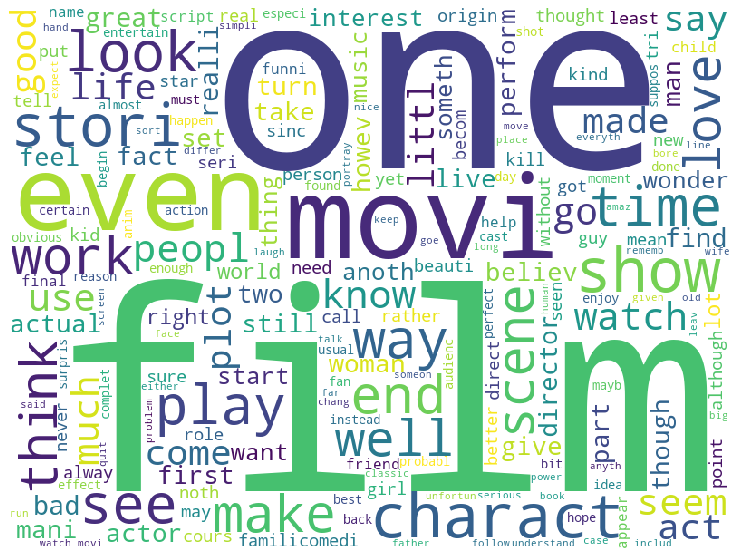

Wall time: 15 s


In [26]:
%time displayWordCloud(' '.join(clean_train_reviews))

In [27]:
x = clean_train_reviews[0]
x = str(x).split()
print(len(x))
x[:10]
print(len(set(x)))

219
156


In [31]:
# 단어 수
len_rev = []
for review in clean_train_reviews:
    len_rev.append(len(str(review).split()))
train['num_words'] = len_rev

In [32]:
# 중복을 제거한 단어 수
len_uni = []
for review in clean_train_reviews:
    len_uni.append(len(set(str(review).split())))
train['num_unique_words'] = len_uni

In [33]:
train.head()

,id,sentiment,review,num_words,num_unique_words
0,"""5814_8""",1,"""With all this stuff going down at the moment ...",219,156
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ...",84,63
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell...",240,201
3,"""3630_4""",0,"""It must be assumed that those who praised thi...",189,158
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ...",210,188


#### 데이터 시각화

In [36]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['axes.unicode_minus'] = False   # minus 표시
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 10
%matplotlib inline

리뷰별 단어 평균 값 : 119.52356
리뷰별 단어 중간 값 : 89.0
리뷰별 고유단어 평균 값 : 94.02668
리뷰별 고유단어 중간 값 : 74.0


Text(0.5, 1.0, '리뷰별 고유단어 수 분포')

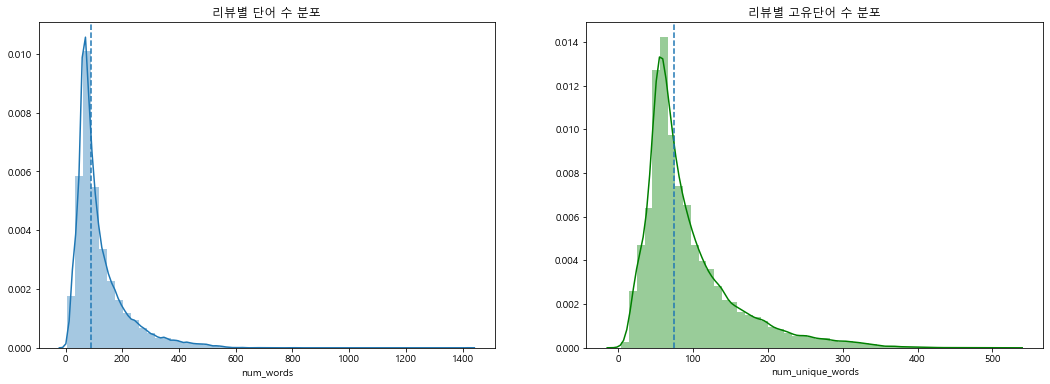

In [38]:
import seaborn as sns

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(18, 6)
print('리뷰별 단어 평균 값 :', train['num_words'].mean())
print('리뷰별 단어 중간 값 :', train['num_words'].median())
sns.distplot(train['num_words'], ax=axes[0])
axes[0].axvline(train['num_words'].median(), linestyle='dashed')
axes[0].set_title('리뷰별 단어 수 분포')

print('리뷰별 고유단어 평균 값 :', train['num_unique_words'].mean())
print('리뷰별 고유단어 중간 값 :', train['num_unique_words'].median())
sns.distplot(train['num_unique_words'], color='g', ax=axes[1])
axes[1].axvline(train['num_unique_words'].median(), linestyle='dashed')
axes[1].set_title('리뷰별 고유단어 수 분포')

In [39]:
train.to_excel("data/01.IMDB_review.xlsx")

## III. 텍스트 데이터 벡터화

### Scikit-learn의 CountVectorizer를 통해 Feature 생성
- 정규표현식을 사용해 토큰 추출
- 소문자로 변환해서 작업 수행
- 의미없는 특성이 많이 생성되므로 적어도 두개의 문서에 나타난 토큰만 사용
- min_df로 토큰이 나타날 최소문서개수 지정 가능

In [40]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = 'word', tokenizer = None, stop_words = None,
                             min_df = 2,     # 토큰이 나타날 최소 문서
                             ngram_range = (1,3), max_features = 20000)
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=20000, min_df=2,
                ngram_range=(1, 3), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [42]:
%time train_data_features = vectorizer.fit_transform(clean_train_reviews)
train_data_features

Wall time: 25.6 s


<25000x20000 sparse matrix of type '<class 'numpy.int64'>'
	with 2759359 stored elements in Compressed Sparse Row format>

In [43]:
train_data_features.shape

(25000, 20000)

In [48]:
train_data_features[0]

<1x20000 sparse matrix of type '<class 'numpy.int64'>'
	with 191 stored elements in Compressed Sparse Row format>

In [52]:
import pandas as pd
pd.DataFrame(train_data_features[:10].toarray(), columns=vocab).head()

,aag,aaron,ab,abandon,abbey,abbi,abbot,abbott,abc,abduct,...,zombi bloodbath,zombi film,zombi flick,zombi movi,zone,zoo,zoom,zorro,zu,zucker
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

20000


['aag',
 'aaron',
 'ab',
 'abandon',
 'abbey',
 'abbi',
 'abbot',
 'abbott',
 'abc',
 'abduct']

In [50]:
vocab[-5:]

['zoo', 'zoom', 'zorro', 'zu', 'zucker']

In [45]:
# 벡터화된 피쳐 확인
import numpy as np
dist = np.sum(train_data_features, axis = 0)

for tag, count in zip(vocab, dist):
    print(count, tag)

[[26 48 22 ... 59 40 23]] aag


In [51]:
pd.DataFrame(dist, columns=vocab)

,aag,aaron,ab,abandon,abbey,abbi,abbot,abbott,abc,abduct,...,zombi bloodbath,zombi film,zombi flick,zombi movi,zone,zoo,zoom,zorro,zu,zucker
0,26,48,22,288,24,30,29,30,125,55,...,23,52,37,89,161,31,71,59,40,23


## IV. Random Forest로 영화감성 예측

In [55]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators = 100,
                                n_jobs = -1,
                                random_state = 2019)
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=2019, verbose=0,
                       warm_start=False)

In [56]:
forest = forest.fit(train_data_features, train['sentiment'])

In [57]:
from sklearn.model_selection import cross_val_score
%time score = np.mean(cross_val_score(\
                    forest, train_data_features, \
                    train['sentiment'], cv=10, scoring='roc_auc'))

Wall time: 2min 5s


In [58]:
# 정제한 테스트 리뷰의 첫번째 데이터 확인
clean_test_reviews[0]

'natur film main theme mortal nostalgia loss innoc perhap surpris rate high older viewer younger one howev craftsmanship complet film anyon enjoy pace steadi constant charact full engag relationship interact natur show need flood tear show emot scream show fear shout show disput violenc show anger natur joyc short stori lend film readi made structur perfect polish diamond small chang huston make inclus poem fit neat truli masterpiec tact subtleti overwhelm beauti'

In [59]:
test_data_features = vectorizer.fit_transform(clean_test_reviews)
test_data_features = test_data_features.toarray()
test_data_features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [60]:
# 데이터 확인
test_data_features[5][:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [61]:
# 벡터화하며 만든 사전에서 해당 단어가 무엇인지 확인
# vocab = vectorizer.get_feature_names()
vocab[8], vocab[2558], vocab[2559], vocab[2560]

('abc', 'charact pretti', 'charact quit', 'charact rather')

In [62]:
# 테스트 데이터에 대한 예측
result = forest.predict(test_data_features)
result[:10]

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0], dtype=int64)

In [63]:
# 예측 결과 데이터프레임으로 만들어 저장
output = pd.DataFrame(data={'id':test['id'], 'sentiment':result})
output.head()

,id,sentiment
0,"""12311_10""",0
1,"""8348_2""",0
2,"""5828_4""",0
3,"""7186_2""",0
4,"""12128_7""",1


In [64]:
score

0.9287137919999999

In [65]:
output.to_csv('data/01.IMDB_{0:.5f}.csv'.format(score), index=False, quoting=3)

**Kaggle competition score: 0.52515**

In [66]:
output['sentiment'].value_counts()

1    13443
0    11557
Name: sentiment, dtype: int64